In [ ]:
! pip install -q "gdown==5.2.0" "datasets==2.20.0" "flash_attn==2.6.3" "timm==1.0.8" "einops==0.8.0" "transformers==4.44.0" pillow huggingface_hub

In [2]:
from google.colab import userdata
from huggingface_hub import login

In [ ]:
login(token=userdata.get('niru_hf_read'))

In [4]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoProcessor
import torch
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import Dataset
import requests
from PIL import Image
import random
import pandas as pd
import numpy as np
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split

# Dataset

In [ ]:
!gdown --id 1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39

In [ ]:
!unzip lung_cancer_dataset.zip

In [7]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='image')
    Lseries = pd.Series(labels, name='text')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [8]:
data_dir = '/content/lung_cancer_dataset'
df = loading_the_data(data_dir)
df

image             text
0     /content/lung_cancer_dataset/Normal cases/Norm...     Normal cases
1     /content/lung_cancer_dataset/Normal cases/Norm...     Normal cases
2     /content/lung_cancer_dataset/Normal cases/Norm...     Normal cases
3     /content/lung_cancer_dataset/Normal cases/Norm...     Normal cases
4     /content/lung_cancer_dataset/Normal cases/Norm...     Normal cases
...                                                 ...              ...
1195  /content/lung_cancer_dataset/Malignant cases/M...  Malignant cases
1196  /content/lung_cancer_dataset/Malignant cases/M...  Malignant cases
1197  /content/lung_cancer_dataset/Malignant cases/M...  Malignant cases
1198  /content/lung_cancer_dataset/Malignant cases/M...  Malignant cases
1199  /content/lung_cancer_dataset/Malignant cases/M...  Malignant cases

[1200 rows x 2 columns]

# Model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')
torch.cuda.empty_cache()

# Prepare the Dataset

In [11]:
class LungCancerDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['text']
        question = "<DocVQA>" + "What is the type of lung cancer?"
        first_answer = label
        image = Image.open(img_path).convert("RGB")

        return question, first_answer, image

In [12]:
img_size = (224, 224)

train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

classes = train_df['text'].unique()
class_dict = {label: idx for idx, label in enumerate(classes)}
reverse_class_dict = {idx: label for label, idx in class_dict.items()}

train_dataset = LungCancerDataset(dataframe=train_df)
valid_dataset = LungCancerDataset(dataframe=valid_df)
test_dataset = LungCancerDataset(dataframe=test_df)

In [13]:
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

batch_size = 2
num_workers = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

# Before Training the model
Test the base model

In [14]:
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer

for idx in range(3):
  question, answer, image = train_dataset[idx]
  print(run_example("DocVQA", 'What is this image?', image))


{'DocVQA': 'unanswerable'}
{'DocVQA': 'no'}
{'DocVQA': 'unanswerable'}


# Train Model

In [15]:
from transformers import AdamW, AutoProcessor, get_scheduler

In [16]:
def train_model(train_loader, val_loader, model, processor, epochs=5, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

In [17]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

train_model(train_loader, val_loader, model, processor)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/5: 100%|██████████| 480/480 [03:12<00:00,  2.50it/s]


Average Training Loss: 1.6078203848330304


Validation Epoch 1/5: 100%|██████████| 60/60 [00:09<00:00,  6.24it/s]


Average Validation Loss: 0.4617898956562082


Training Epoch 2/5: 100%|██████████| 480/480 [03:11<00:00,  2.51it/s]


Average Training Loss: 0.4904662305120534


Validation Epoch 2/5: 100%|██████████| 60/60 [00:09<00:00,  6.22it/s]


Average Validation Loss: 0.211442429634432


Training Epoch 3/5: 100%|██████████| 480/480 [03:11<00:00,  2.51it/s]


Average Training Loss: 0.23616894802592772


Validation Epoch 3/5: 100%|██████████| 60/60 [00:09<00:00,  6.20it/s]


Average Validation Loss: 0.10950580003748958


Training Epoch 4/5: 100%|██████████| 480/480 [03:11<00:00,  2.51it/s]


Average Training Loss: 0.14570729972062205


Validation Epoch 4/5: 100%|██████████| 60/60 [00:09<00:00,  6.22it/s]


Average Validation Loss: 0.05654981820310544


Training Epoch 5/5: 100%|██████████| 480/480 [03:11<00:00,  2.51it/s]


Average Training Loss: 0.10204774288261736


Validation Epoch 5/5: 100%|██████████| 60/60 [00:09<00:00,  6.24it/s]


Average Validation Loss: 0.047595865490438885


# Evaluation

In [19]:
model.eval()
test_loss = 0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs, answers = batch

        input_ids = inputs["input_ids"]
        pixel_values = inputs["pixel_values"]
        labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        test_loss += loss.item()

        # Decode the predicted tokens to text
        predicted_ids = outputs.logits.argmax(dim=-1)
        predicted_texts = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

        # Compare predictions with the actual answers
        for predicted_text, answer in zip(predicted_texts, answers):
            if predicted_text.strip() == answer.strip():
                correct_predictions += 1
            total_predictions += 1

    avg_test_loss = test_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions

    print(f"Average test Loss: {avg_test_loss}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


100%|██████████| 60/60 [00:09<00:00,  6.13it/s]

Average test Loss: 0.048236686422023924
Test Accuracy: 99.17%


In [20]:
for idx in range(3):
  question, answer, image = train_dataset[idx]
  print(run_example("DocVQA", 'What is the type of lung cancer', image))

{'DocVQA': 'Normal cases'}
{'DocVQA': 'Bengin cases'}
{'DocVQA': 'Normal cases'}


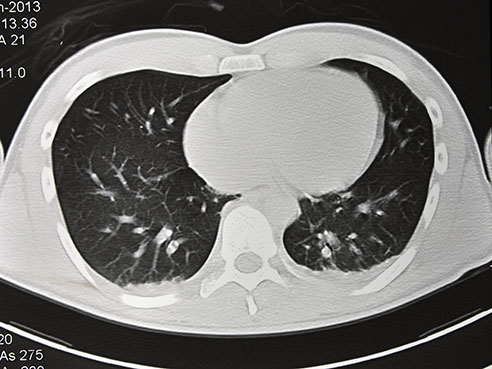

In [21]:
url = "https://www.uab.edu/news/images/ct_scan.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

In [22]:
run_example("DocVQA", 'What is the type of lung cancer', image)

{'DocVQA': 'Malignant cases'}

In [24]:
image = Image.open("/content/image_case.jpg").convert("RGB")
run_example("DocVQA", 'What is the type of lung cancer', image)

{'DocVQA': 'Bengin cases'}

# Push the Model to the Hub

In [ ]:
login(token=userdata.get('niru_hf_write'))

In [ ]:
repo_name = "Florence-2_FT_Lung-Cancer-detection"

model.push_to_hub(repo_name,
                  safe_serialization=True,
                  commit_message="fine tuned florence-2 model for Lung-Cancer-detection",
                  private=True,
                  )

processor.push_to_hub(repo_name, private=True)